# Case3-challenge01

At first, we add the analysis directory to the python path.

In [1]:
import sys
sys.path.append('/home/kamizuka/analysis')

At first, we load the data, 'case3_chalenge_01.txt'.

In [2]:
import astropy.io.ascii as asc
from astropy import units as u

data = asc.read('case3_challenge_01.txt')
data['x'] = data['x']*1.e-3 # Converting um to mm.
data['y'] = data['y']*1.e-3 # Converting um to mm.
data['x'].unit = u.mm
data['y'].unit = u.mm
data['ra'].unit = u.deg
data['dec'].unit = u.deg

The source distribution is shown in the figure below.

In [3]:
import matplotlib.pylab as plt

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['x'], data['y'], marker='x')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_xlim([-25,25])
ax.set_ylim([-25,25])
ax.set_aspect('equal', adjustable='box')

fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='x')
ax.scatter(data['ra']-360.0, data['dec'], marker='x')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
ax.set_aspect('equal', adjustable='box')

We guess the field parameters.

In [4]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle

r = np.sqrt(data['x']**2.+data['y']**2.)
i0 = np.argmin(r)
ra0  = data['ra'].quantity[i0]
dec0 = data['dec'].quantity[i0]

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs')
c1 = SkyCoord(ra=data['ra'].quantity[0], dec=data['dec'].quantity[0], frame='icrs')
angle_sep = c0.separation(c1)

dx = data['x'].quantity[i0] - data['x'].quantity[0]
dy = data['y'].quantity[i0] - data['y'].quantity[0]
mm_sep = np.sqrt(dx*dx+dy*dy)

scale0 = angle_sep/mm_sep

pa0 = 0.0 * u.deg

print(ra0)
print(dec0)
print(scale0)
print(pa0)

359.99387755102043 deg
-0.006122448979591855 deg
0.007909170042520645 deg / mm
0.0 deg


Here, we define a function to construct a wcs instance from given parameters.

In [5]:
from astropy.wcs import WCS
from astropy.wcs import Sip

def wcs(ra0, dec0, pa0, scale0, a=None, b=None):
    w = WCS(naxis=2)
    w.wcs.crpix=[0,0]
    w.wcs.cdelt=np.array([-scale0, scale0])
    w.wcs.crval=[ra0, dec0]
    w.wcs.ctype=["RA---TAN-SIP", "DEC--TAN-SIP"]
    w.wcs.pc=[[ np.cos(pa0*u.deg), np.sin(pa0*u.deg)],
              [-np.sin(pa0*u.deg), np.cos(pa0*u.deg)]]
    if a is not None and b is not None:
        w.sip = Sip(a, b, None, None, [0, 0])
    return w

Next, we define a model function to estimate the position angle. This function calculates RA and Dec from the position on the focal plane. At this moment, we ignore the distortion.

In [6]:
def model_wo_distortion(params, pxcrd):
    # params must be an ndarray of dimension-less values.
    # assuming params = [ra, dec, pa, scale].
    ra_ptg  = params[0] # value in deg.
    dec_ptg = params[1] # value in deg.
    pa_ptg  = params[2] # value in deg.
    scale   = params[3] # value in deg/mm.
    
    w = wcs(ra_ptg, dec_ptg, pa_ptg, scale)
    world = w.all_pix2world(pixcrd, 0)

    # constraining ra and dec in 'world' between -180 to 180 deg.
    pos = np.where(world>180.)
    world[pos] = world[pos] - 360.
    pos = np.where(world<-180.)
    world[pos] = world[pos] + 360.
    
    return world.T.flatten()

Then, we make an array of the coordinates on the focal plane.

In [7]:
pixcrd = np.concatenate(([data['x']],[data['y']])).T

In [8]:
from common.leastsquare import LeastSquare

ls = LeastSquare(lambda a: model_wo_distortion(a, pixcrd), np.size(data['x'])*2)

# constructing a_init (initial parameter set).
a_init = [ra0.value, dec0.value, pa0.value, scale0.value]
a_init = np.array(a_init) # This must be an ndarray.

# constraining ra/dec values in 'observed' between -180 and 180 deg.
true_pos = np.concatenate((data['ra'], data['dec']))
pos = np.where(true_pos>180.)
true_pos[pos] = true_pos[pos] - 360.
pos = np.where(true_pos<-180.)
true_pos[pos] = true_pos[pos] + 360.

result, _ = ls.solve(true_pos, a_init, max_iteration=100)

if result[3] < 0:
    result[3] = -result[3]
    result[2] = result[2] + 180.0

if result[2] > 360.0 or result[2] < 0.0:
    result[2] = result[2]%360.0

# Showing the results.
print("Center R.A.   : {:f} deg.".format(result[0]))
print("Center Dec.   : {:f} deg.".format(result[1]))
print("Position angle: {:f} deg.".format(result[2]))
print("Plate scale   : {:e} deg/mm".format(result[3]))
    
# Updating the field parameters.
ra0    = result[0] * u.deg
dec0   = result[1] * u.deg
pa0    = result[2] * u.deg
scale0 = result[3] * u.deg/u.mm

2021-07-10 12:18:45,371  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 52.761539)
2021-07-10 12:18:45,380  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 32.367571)
2021-07-10 12:18:45,387  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 19.261963)
2021-07-10 12:18:45,395  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm = 0.171874)
2021-07-10 12:18:45,403  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 5, norm = 0.009460)
2021-07-10 12:18:45,411  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 6, norm = 0.000000)
2021-07-10 12:18:45,419  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 7, norm = 0.000000)
2021-07-10 12:18:45,426  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 8, norm = 0.000000)
2021-

Center R.A.   : 360.004189 deg.
Center Dec.   : 0.001229 deg.
Position angle: 66.029557 deg.
Plate scale   : 7.970686e-03 deg/mm


We define a model function which calculates RA and Dec from the position on the focal plane with considering the distortion. It is represented by the Sip function implemented to astropy.wcs.

In [9]:
def model(params, pxcrd, sip_order):
    # params must be an ndarray of dimension-less values.
    # assuming params = [ra, dec, pa, scale, a00, a01, ..., a0m, a10, a11, ..., amm, b00, b01, ..., bmm].
    ra_ptg  = params[0] # value in deg.
    dec_ptg = params[1] # value in deg.
    pa_ptg  = params[2] # value in deg.
    scale   = params[3] # value in deg/mm.
    a = params[4:4+(sip_order+1)**2].reshape((sip_order+1, sip_order+1))
    b = params[4+(sip_order+1)**2:4+2*(sip_order+1)**2].reshape((sip_order+1, sip_order+1))
    # constraining some parametes to be zero.
    m, n = np.indices((sip_order+1, sip_order+1))
    pos = np.where((m+n==0)+(m+n==1)+(m+n>sip_order))
    a[pos] = 0.
    b[pos] = 0.
    
    w = wcs(ra_ptg, dec_ptg, pa_ptg, scale, a, b)
    world = w.all_pix2world(pixcrd, 0)

    # constraining ra and dec in 'world' between -180 to 180 deg.
    pos = np.where(world>180.)
    world[pos] = world[pos] - 360.
    pos = np.where(world<-180.)
    world[pos] = world[pos] + 360.
    
    return world.T.flatten()

And now, we estimate the field and distortion parameters with the LeastSquare module. Here, we set the sip order to be 4.

In [10]:
from common.leastsquare import LeastSquare

sip_order = 4

ls = LeastSquare(lambda a: model(a, pixcrd, sip_order), np.size(data['x'])*2)

# constructing a_init (initial parameter set).
a_init = [ra0.value, dec0.value, pa0.value, scale0.value]
for i in range(0, 2*(sip_order+1)**2):
    a_init.append(0)
a_init = np.array(a_init) # This must be an ndarray.

# constraining ra/dec values in 'observed' between -180 and 180 deg.
true_pos = np.concatenate((data['ra'], data['dec']))
pos = np.where(true_pos>180.)
true_pos[pos] = true_pos[pos] - 360.
pos = np.where(true_pos<-180.)
true_pos[pos] = true_pos[pos] + 360.

result, _ = ls.solve(true_pos, a_init, max_iteration=100)

if result[3] < 0:
    result[3] = -result[3]
    result[2] = result[2] + 180.0

if result[2] > 360.0 or result[2] < 0.0:
    result[2] = result[2]%360.0

2021-07-10 12:19:29,513  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:19:29,518  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 1, norm = 0.009413)
2021-07-10 12:19:29,676  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:19:29,679  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 2, norm = 0.000123)
2021-07-10 12:19:29,826  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:19:29,829  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 3, norm = 0.000000)
2021-07-10 12:19:29,933  WARNING  common.leastsquare : Cannot calculate inverse matrix. Calculate pseudo-inverse matrix instead.
2021-07-10 12:19:29,936  DEBUG  common.leastsquare : Solving with least square calculation (iteration = 4, norm 

The result is...

In [11]:
print("Center R.A.   : {:f} deg.".format(result[0]))
print("Center Dec.   : {:f} deg.".format(result[1]))
print("Position angle: {:f} deg.".format(result[2]))
print("Plate scale   : {:e} deg/mm".format(result[3]))

Center R.A.   : 360.010319 deg.
Center Dec.   : 0.003960 deg.
Position angle: 66.025905 deg.
Plate scale   : 7.824918e-03 deg/mm


In [12]:
print(result[4:4+(sip_order+1)**2].reshape((sip_order+1, sip_order+1)))
print(result[4+(sip_order+1)**2:].reshape((sip_order+1, sip_order+1)))

[[ 0.00000000e+00  0.00000000e+00  1.01346518e-03 -3.46321594e-06
   3.68359281e-07]
 [ 0.00000000e+00  1.96845857e-03  9.57474290e-06  1.99347867e-07
   0.00000000e+00]
 [ 3.41586957e-03  2.19199766e-05  1.40446855e-07  0.00000000e+00
   0.00000000e+00]
 [ 1.14376080e-05  2.57058471e-07  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-5.14043111e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00  3.10857035e-03  9.11312181e-06
  -1.43794151e-07]
 [ 0.00000000e+00  2.19323878e-03  2.18185749e-05  2.28927261e-07
   0.00000000e+00]
 [ 8.99975868e-04  9.93042882e-06  1.40655564e-07  0.00000000e+00
   0.00000000e+00]
 [-3.38590728e-06  1.90521744e-07  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.84416434e-07  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


According to the meta part of the input file, the poiunting RA and Dec are 0.0 deg. The position angle is 66.02562354723618 deg. The calculation seems to correctly estimate these parameters.

Let's compare the ra/dec values calculated from the derived parameters with the true values.

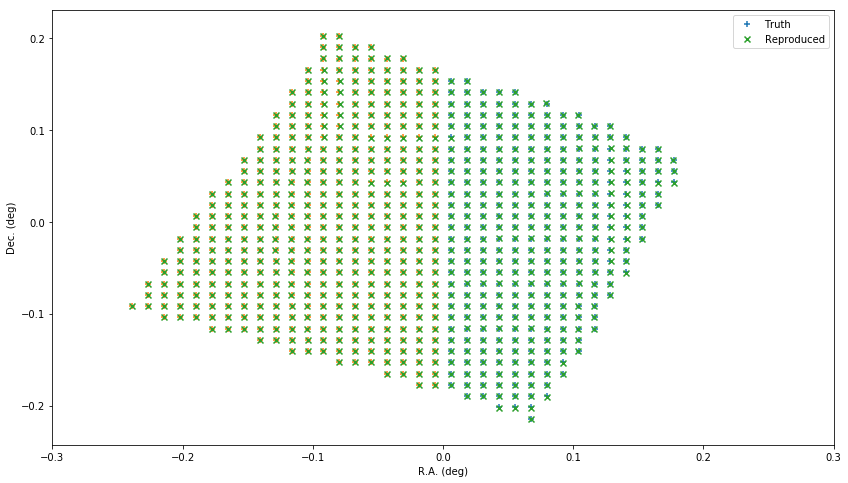

In [13]:
positions = model(result, pixcrd, sip_order)
positions = positions.reshape((2,int(positions.size/2))).T

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)
ax.scatter(data['ra'], data['dec'], marker='+', label='Truth')
ax.scatter(data['ra']-360., data['dec'], marker='+', label='')
ax.scatter(positions[:,0], positions[:,1], marker='x', label='Reproduced')
ax.set_xlabel('R.A. (deg)')
ax.set_ylabel('Dec. (deg)')
ax.set_xlim([-0.3,0.3])
#ax.set_aspect('equal', adjustable='box')
ax.legend()

The reproduced ra/dec values seem to match the true values very well.

In [14]:
from astropy.coordinates import SkyCoord

c_calc = SkyCoord(positions[:,0]*u.deg, positions[:,1]*u.deg, frame='icrs')
c_true = SkyCoord(data['ra'], data['dec'], frame='icrs')
sep = c_calc.separation(c_true)

Text(0, 0.5, 'Position estimation error (arcsec)')

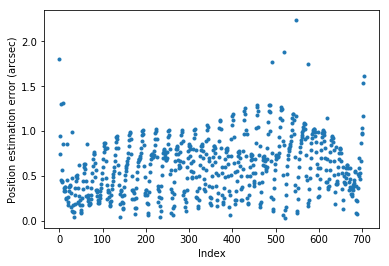

In [15]:
plt.plot(sep.arcsec, '.')
plt.xlabel('Index')
plt.ylabel('Position estimation error (arcsec)')

The position difference is small, typically around <1 arcsec.